# Activations & Gradients, BatchNorm
This is the third part of building makemore and is based on the lecture [Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc) by [Andrey Karpathy](https://github.com/karpathy).

In this lecture we dive into some of the internals of MLPs with multiple layers and scrutinize the statistics of the forward pass activations, backward pass gradients, and some of the pitfalls when they are improperly scaled. We also look at the typical diagnostic tools and visualizations you'd want to use to understand the health of your deep network. We learn why training deep neural nets can be fragile and introduce the first modern innovation that made doing so much easier: Batch Normalization.

After a deepdive in MLPs we take a look at more complex and larger neural networks, like RNN ([Recurrent neural network](https://en.wikipedia.org/wiki/Recurrent_neural_network)) and its variations like GRU ([Gated recurrent unit](https://en.wikipedia.org/wiki/Recurrent_neural_network)).

## Code Setup
Mostly parallel to [Part 2](https://github.com/AndreasMing/Learning/blob/main/NN_Makemore/NeuralnetsWithMakemore_2.ipynb).

In [1]:
# setup
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

# read all the words
words =  open('MakemoreNames.txt', 'r').read().splitlines()
print(f'number of words: {len(words)}')

number of words: 32033


In [2]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}      # give each character its corresponding number (a=1,...)
stoi['.'] = 0                                   # add special character at pos 0
itos = {i:s for s,i in stoi.items()}            # now every number (i) has a corresponding character (s) --> i to s
vocab_size = len(itos)
print(f'itos: {itos}')
print(f'\nSize of vocabulary: {vocab_size}')

itos: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}

Size of vocabulary: 27


In [3]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(f'Shape of X: {X.shape}\t Shape of Y: {Y.shape}')
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80% training split
Xdev, Ydev = build_dataset(words[n1:n2])   # 10% dev split
Xte,  Yte  = build_dataset(words[n2:])     # 10% test split

Shape of X: torch.Size([182625, 3])	 Shape of Y: torch.Size([182625])
Shape of X: torch.Size([22655, 3])	 Shape of Y: torch.Size([22655])
Shape of X: torch.Size([22866, 3])	 Shape of Y: torch.Size([22866])


In [4]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
"""
# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))"""

parameters = [C, W1, b1, W2, b2]#, bngain, bnbias]
print(f'Number of parameters: {sum(p.nelement() for p in parameters)}') # number of parameters in total
for p in parameters:
  p.requires_grad = True

Number of parameters: 11897


In [12]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
whuat = 0

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  """
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  """
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f} \tNone: {whuat}')
  lossi.append(loss.log10().item())

      0/  20000: 2.5020 	None: 0
  10000/  20000: 2.1103 	None: 0


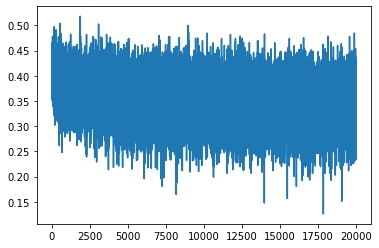

In [13]:
plt.plot(lossi)

https://youtu.be/P6sfmUTpUmc?t=134